In [107]:
import os
import re
import glob
from pathlib import Path
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import plotly.express as px
from IPython.display import display, HTML
import math
from datetime import datetime
import ipywidgets as widgets
from plotly.subplots import make_subplots
from tensorboard.backend.event_processing import event_accumulator

display(HTML("<style>:root { --jp-notebook-max-width: 100% !important; }</style>"))

def find_latest_log_dir(base_dir="runs"):
    dirs = glob.glob(os.path.join(base_dir, "exp_*"))
    if not dirs:
        return None
    return max(dirs, key=os.path.getctime)

def parse_tag_name(tag):
    match = re.match(r'model_ds(\d+)_p(\d+)/(?:train|val)(?:_(.+))?_loss', tag)
    if match:
        ds_size = int(match.group(1))
        params = int(match.group(2))
        metric_type = match.group(3) if match.group(3) else ''
        is_train = 'train' in tag
        metric = f"{'train' if is_train else 'val'}{('_' + metric_type) if metric_type else ''}_loss"
        return ds_size, params, metric
    
    match = re.match(r'model_ds(\d+)_p(\d+)/(train|val)__loss', tag)
    if match:
        ds_size = int(match.group(1))
        params = int(match.group(2))
        is_train = match.group(3) == 'train'
        metric = f"{'train' if is_train else 'val'}_loss"
        return ds_size, params, metric
    
    return None, None, tag

def format_number(num):
    if num >= 1e9:
        return f"{num/1e9:.1f}B"
    elif num >= 1e6:
        return f"{num/1e6:.1f}M"
    elif num >= 1e3:
        return f"{num/1e3:.1f}K"
    else:
        return f"{num:.1f}"

def load_tensorboard_data(log_dir):
    all_data = []    
    event_files = glob.glob(os.path.join(log_dir, "event*"))
    
    if not event_files:
        return pd.DataFrame()
        
    for event_file in event_files:
        try:
            ea = event_accumulator.EventAccumulator(
                event_file,
                size_guidance={event_accumulator.SCALARS: 0}
            )
            ea.Reload()
            
            tags = ea.Tags()['scalars']
            if len(tags) == 0:
                continue
            
            for tag in tags:
                if any(skip in tag for skip in ['Grads', 'G2W']):
                    continue
                    
                ds_size, params, metric = parse_tag_name(tag)
                if ds_size is None:
                    continue
                
                events = ea.Scalars(tag)
                
                for event in events:
                    if math.isnan(event.value):
                        continue
                    
                    record = {
                        'log_dir': os.path.basename(log_dir),
                        'dataset_size': ds_size,
                        'params': params,
                        'metric': metric,
                        'epoch': event.step,
                        'value': event.value,
                        'wall_time': event.wall_time
                    }
                    all_data.append(record)
                    
        except Exception:
            continue
    
    return pd.DataFrame(all_data) if all_data else pd.DataFrame()

def combine_stress_data(iso_df, aniso_df):
    if iso_df.empty or aniso_df.empty:
        return pd.DataFrame()
        
    iso_grouped = iso_df.groupby(['params', 'epoch'])['value'].mean().reset_index()
    aniso_grouped = aniso_df.groupby(['params', 'epoch'])['value'].mean().reset_index() 
    
    merged = pd.merge(
        iso_grouped,
        aniso_grouped,
        on=['params', 'epoch'],
        suffixes=('_iso', '_aniso')
    )        
    
    merged['value'] = merged['value_iso'] + merged['value_aniso']
    return merged

def prepare_best_losses(df):
    if df.empty:
        return {}
        
    val_metrics = df[df['metric'].str.contains('val', na=False)]
    if val_metrics.empty:
        return {}
    
    overall_metric = 'val_loss'
    if df[df['metric'] == 'val_loss'].empty:
        overall_metric = 'val_energy_loss'
    
    overall_df = df[df['metric'] == overall_metric]
    if overall_df.empty:
        return {}
    
    min_loss_epochs = overall_df.loc[
        overall_df.groupby(['log_dir', 'dataset_size', 'params'])['value'].idxmin()
    ][['log_dir', 'dataset_size', 'params', 'epoch', 'value']]
    
    min_loss_epochs = min_loss_epochs.rename(columns={'value': 'best_overall_loss'})
    
    metric_types = {
        'overall': overall_metric,
        'energy': 'val_energy_loss',
        'force': 'val_force_loss',
        'stress': None
    }
    
    results = {'overall': min_loss_epochs.copy()}
    
    for metric_key, metric_name in metric_types.items():
        if metric_key == 'overall' or metric_name is None:
            continue
            
        metric_df = df[df['metric'] == metric_name]
        if metric_df.empty:
            continue
        
        merged_df = pd.merge(
            min_loss_epochs,
            metric_df,
            on=['log_dir', 'dataset_size', 'params', 'epoch'],
            suffixes=('_overall', '')
        )
        
        if merged_df.empty:
            continue
            
        metric_result = merged_df[['log_dir', 'dataset_size', 'params', 'epoch', 'value']]
        results[metric_key] = metric_result
    
    stress_iso_df = df[df['metric'] == 'val_stress_iso_loss'].copy()
    stress_aniso_df = df[df['metric'] == 'val_stress_aniso_loss'].copy()
    
    if not stress_iso_df.empty and not stress_aniso_df.empty:
        stress_iso_df = stress_iso_df.rename(columns={'value': 'iso_value'})
        iso_merged = pd.merge(
            min_loss_epochs,
            stress_iso_df,
            on=['log_dir', 'dataset_size', 'params', 'epoch']
        )
        
        stress_aniso_df = stress_aniso_df.rename(columns={'value': 'aniso_value'})
        stress_merged = pd.merge(
            iso_merged,
            stress_aniso_df,
            on=['log_dir', 'dataset_size', 'params', 'epoch']
        )
        
        if not stress_merged.empty:
            stress_merged['value'] = stress_merged['iso_value'] + stress_merged['aniso_value']
            
            stress_result = stress_merged[['log_dir', 'dataset_size', 'params', 'epoch', 'value']]
            results['stress'] = stress_result
    
    return results

def load_data_from_selection(log_dir):
    if not os.path.exists(log_dir):
        print(f"Directory does not exist: {log_dir}")
        return None, None
    
    df = load_tensorboard_data(log_dir)
    if not df.empty:
        best_losses = prepare_best_losses(df)
        return df, best_losses
    else:
        return None, None

def create_subplot_figure(row_count, col_count, titles, spacing=0.15):
    return make_subplots(
        rows=row_count,
        cols=col_count,
        subplot_titles=titles,
        vertical_spacing=spacing,
        horizontal_spacing=spacing
    )

def setup_figure_layout(fig, title, width=1250, height=1000):
    fig.update_layout(
        title=title,
        width=width,
        height=height,
        template="plotly_white",
        legend=dict(
            yanchor="top",
            y=0.99,
            xanchor="right",
            x=0.99
        )
    )
    return fig

def plot_model_comparisons(best_losses):
    if not best_losses:
        return None
    
    metric_keys = list(best_losses.keys())
    titles = {
        'overall': 'Overall Validation Loss',
        'energy': 'Energy Loss',
        'force': 'Force Loss',
        'stress': 'Stress Loss'
    }
    
    rows = min(2, len(metric_keys))
    cols = (len(metric_keys) + rows - 1) // rows
    
    fig = create_subplot_figure(rows, cols, [titles.get(key, key) for key in metric_keys])
    
    all_params = set()
    for key in metric_keys:
        all_params.update(best_losses[key]['params'].unique())
    
    color_map = {size: px.colors.qualitative.Plotly[i % len(px.colors.qualitative.Plotly)] 
                 for i, size in enumerate(sorted(all_params))}
    
    for i, key in enumerate(metric_keys):
        row = i // cols + 1
        col = i % cols + 1
        best_val_loss = best_losses[key]
        
        for model_size in sorted(best_val_loss['params'].unique()):
            model_data = best_val_loss[best_val_loss['params'] == model_size].sort_values('dataset_size')
            
            show_in_legend = (i == 0)
            name = f"{format_number(model_size)} params"
            y_values = model_data['best_overall_loss'] if key == 'overall' else model_data['value']
            
            fig.add_trace(
                go.Scatter(
                    x=model_data['dataset_size'],
                    y=y_values,
                    mode='lines+markers',
                    name=name,
                    line=dict(color=color_map[model_size]),
                    marker=dict(color=color_map[model_size], size=8),
                    showlegend=show_in_legend,
                    hovertemplate=(
                        "Dataset size: %{x}<br>"
                        f"Loss: %{{y}}<br>"
                        f"Params: {format_number(model_size)}"
                        "<extra></extra>"
                    )
                ),
                row=row, col=col
            )
    
    fig = setup_figure_layout(fig, "")
    
    for i in range(1, rows*cols+1):
        row_idx = (i-1)//cols+1
        col_idx = (i-1)%cols+1
        fig.update_xaxes(type="log", title_text="Dataset Size", row=row_idx, col=col_idx)
        fig.update_yaxes(title_text="Loss Value", row=row_idx, col=col_idx)
    
    return fig

def plot_comprehensive_loss_curves(df, dataset_size):
    if df.empty:
        return None
    
    ds_data = df[df['dataset_size'] == dataset_size]
    if ds_data.empty:
        return None
    
    loss_types = [
        ('train_loss', 'Train Loss'),
        ('val_loss', 'Validation Loss'),
        ('train_energy_loss', 'Train Energy Loss'),
        ('val_energy_loss', 'Validation Energy Loss'),
        ('train_force_loss', 'Train Force Loss'),
        ('val_force_loss', 'Validation Force Loss'),
        ('train_stress', 'Train Stress Loss (Iso+Aniso)'),
        ('val_stress', 'Validation Stress Loss (Iso+Aniso)')
    ]
    
    fig = create_subplot_figure(4, 2, [title for _, title in loss_types], spacing=0.1)
    
    all_params = sorted(ds_data['params'].unique())
    color_map = {size: px.colors.qualitative.Plotly[i % len(px.colors.qualitative.Plotly)] 
                for i, size in enumerate(all_params)}
    
    stress_pairs = [
        ('train_stress', ds_data[ds_data['metric'] == 'train_stress_iso_loss'].copy(),
                      ds_data[ds_data['metric'] == 'train_stress_aniso_loss'].copy()),
        ('val_stress', ds_data[ds_data['metric'] == 'val_stress_iso_loss'].copy(),
                     ds_data[ds_data['metric'] == 'val_stress_aniso_loss'].copy())
    ]
    
    stress_data = {}
    for key, iso_df, aniso_df in stress_pairs:
        stress_data[key] = combine_stress_data(iso_df, aniso_df)
    
    for i, (metric_key, title) in enumerate(loss_types):
        row = i // 2 + 1
        col = i % 2 + 1
        
        if metric_key in stress_data:
            data_to_plot = stress_data[metric_key]
            is_combined = True
        else:
            data_to_plot = ds_data[ds_data['metric'] == metric_key]
            is_combined = False
        
        if data_to_plot.empty:
            continue
        
        for params in sorted(ds_data['params'].unique()):
            model_data = data_to_plot[data_to_plot['params'] == params]
            
            if model_data.empty:
                continue
                
            model_data = model_data.sort_values('epoch')
            
            fig.add_trace(
                go.Scatter(
                    x=model_data['epoch'],
                    y=model_data['value'],
                    mode='lines+markers',
                    name=f"{params} params",
                    line=dict(color=color_map[params]),
                    marker=dict(size=6, color=color_map[params]),
                    showlegend=(i == 0),
                    hovertemplate='Epoch: %{x}<br>Loss: %{y}<extra></extra>'
                ),
                row=row, col=col
            )
    
    fig = setup_figure_layout(fig, "", 1500, 1200)
    
    for i in range(1, 9):
        row_idx = (i-1) // 2 + 1
        col_idx = (i-1) % 2 + 1
        fig.update_xaxes(title_text="Epoch", row=row_idx, col=col_idx)
        fig.update_yaxes(title_text="Loss Value", row=row_idx, col=col_idx)
    
    return fig

def plot_params_vs_losses(best_losses):
    if not best_losses:
        return None
    
    loss_types = [
        ('overall', 'Overall Validation Loss'),
        ('energy', 'Energy Loss'),
        ('force', 'Force Loss'),
        ('stress', 'Stress Loss (Iso+Aniso)')
    ]
    
    fig = create_subplot_figure(2, 2, [title for _, title in loss_types])
    
    all_ds_sizes = set()
    for key in [t[0] for t in loss_types]:
        if key in best_losses:
            all_ds_sizes.update(best_losses[key]['dataset_size'].unique())
    
    color_map = {size: px.colors.qualitative.Plotly[i % len(px.colors.qualitative.Plotly)] 
                for i, size in enumerate(sorted(all_ds_sizes))}
    
    for i, (key, title) in enumerate(loss_types):
        row = i // 2 + 1
        col = i % 2 + 1
        
        if key not in best_losses:
            continue
            
        best_val_loss = best_losses[key]
        
        for ds_size in sorted(best_val_loss['dataset_size'].unique()):
            ds_data = best_val_loss[best_val_loss['dataset_size'] == ds_size].sort_values('params')
            
            if len(ds_data) <= 1:
                continue
                
            y_values = ds_data['best_overall_loss'] if key == 'overall' else ds_data['value']
            
            fig.add_trace(
                go.Scatter(
                    x=ds_data['params'],
                    y=y_values,
                    mode='lines+markers',
                    name=f"Dataset Size: {ds_size}",
                    line=dict(color=color_map[ds_size]),
                    marker=dict(color=color_map[ds_size], size=8),
                    showlegend=(i == 0),
                    hovertemplate=(
                        "Params: %{x}<br>"
                        f"Loss: %{{y}}<br>"
                        f"Dataset Size: {ds_size}"
                        "<extra></extra>"
                    )
                ),
                row=row, col=col
            )
    
    fig = setup_figure_layout(fig, "Validation Loss vs Model Parameters")
    
    for i in range(1, 5):
        row_idx = (i-1) // 2 + 1
        col_idx = (i-1) % 2 + 1
        fig.update_xaxes(type="log", title_text="Model Parameters", row=row_idx, col=col_idx)
        fig.update_yaxes(title_text="Loss Value", row=row_idx, col=col_idx)
    
    return fig

In [108]:
log_dirs = glob.glob(os.path.join("runs", "exp_*"))
log_dirs.sort(key=os.path.getctime, reverse=True)  # Sort by creation time
if not log_dirs:
    print("No TensorBoard logs found in the 'runs' directory.")
else:
    options = [(f"{os.path.basename(log_dir)}", log_dir) for log_dir in log_dirs]
    directory_selector = widgets.SelectMultiple(
        options=options,
        value=[log_dirs[0]],  # Default to most recent
        description='Log directories:',
        style={'description_width': 'initial'},
        layout=widgets.Layout(width='500px', height='150px')
    )
    load_button = widgets.Button(
        description='Load Data',
        button_style='primary',
        tooltip='Load data from selected directories',
        layout=widgets.Layout(width='200px')
    )
    display(widgets.VBox([directory_selector, load_button]))
    load_output = widgets.Output()
    display(load_output)
    
    def on_load_button_clicked(b):
        with load_output:
            load_output.clear_output()
            selected_dirs = directory_selector.value   
            if not selected_dirs:
                print("Please select at least one log directory.")
                return           
            print(f"Loading data from {len(selected_dirs)} directories...")
            global df, best_losses
            all_data = []
            for log_dir in selected_dirs:
                print(f"Processing {os.path.basename(log_dir)}...")
                current_df = load_tensorboard_data(log_dir)
                if not current_df.empty:
                    all_data.append(current_df)
            if all_data:
                df = pd.concat(all_data, ignore_index=True)
                print(f"Successfully loaded {len(df)} data points from {len(selected_dirs)} directories.")
                best_losses = prepare_best_losses(df)
            else:
                df = pd.DataFrame()
                best_losses = {}
                print("No data could be loaded from the selected directories.")    
    load_button.on_click(on_load_button_clicked)

Output()

Creating model comparison plots...


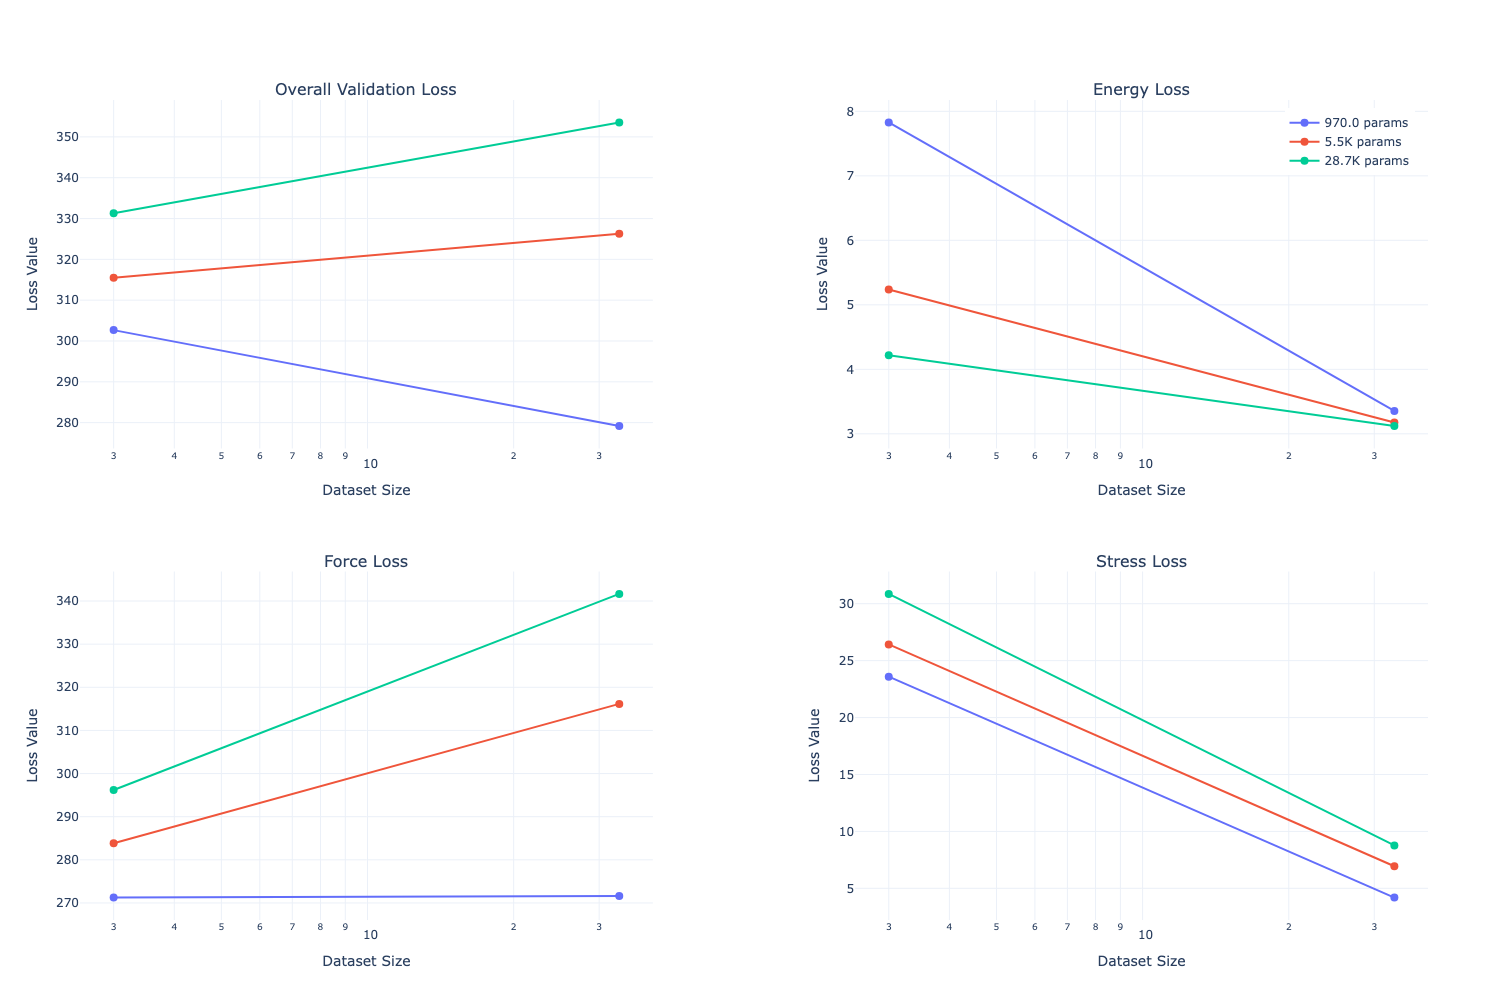

In [109]:
if 'best_losses' in globals() and best_losses:
    print("Creating model comparison plots...")
    fig = plot_model_comparisons(best_losses)
    if fig:
        fig.show()
else:
    print("No data loaded. Please load data first.")

In [110]:
if 'df' in globals() and not df.empty:
    dataset_sizes = sorted(df['dataset_size'].unique())
    if dataset_sizes:
        dataset_dropdown = widgets.Dropdown(
            options=[(f"Size: {ds}", ds) for ds in dataset_sizes],
            value=dataset_sizes[0],
            description='Dataset Size:',
            style={'description_width': 'initial'},
            layout=widgets.Layout(width='300px')
        )        
        loss_plot_output = widgets.Output()
        def on_dataset_change(change):
            with loss_plot_output:
                loss_plot_output.clear_output()
                dataset_size = change['new']
                print(f"Generating loss plots for dataset size {dataset_size}...")
                fig = plot_comprehensive_loss_curves(df, dataset_size)
                if fig:
                    fig.show()
                else:
                    print(f"Could not create plots for dataset size {dataset_size}.")        
        dataset_dropdown.observe(on_dataset_change, names='value')
        display(dataset_dropdown)
        display(loss_plot_output)        
        with loss_plot_output:
            print(f"Generating loss plots for dataset size {dataset_sizes[0]}...")
            fig = plot_comprehensive_loss_curves(df, dataset_sizes[0])
            if fig:
                fig.show()
    else:
        print("No dataset sizes found in the data.")
else:
    print("No data loaded. Please load data first.")

Dropdown(description='Dataset Size:', layout=Layout(width='300px'), options=(('Size: 3', 3), ('Size: 33', 33))…

Output()

Creating parameter vs loss plots...


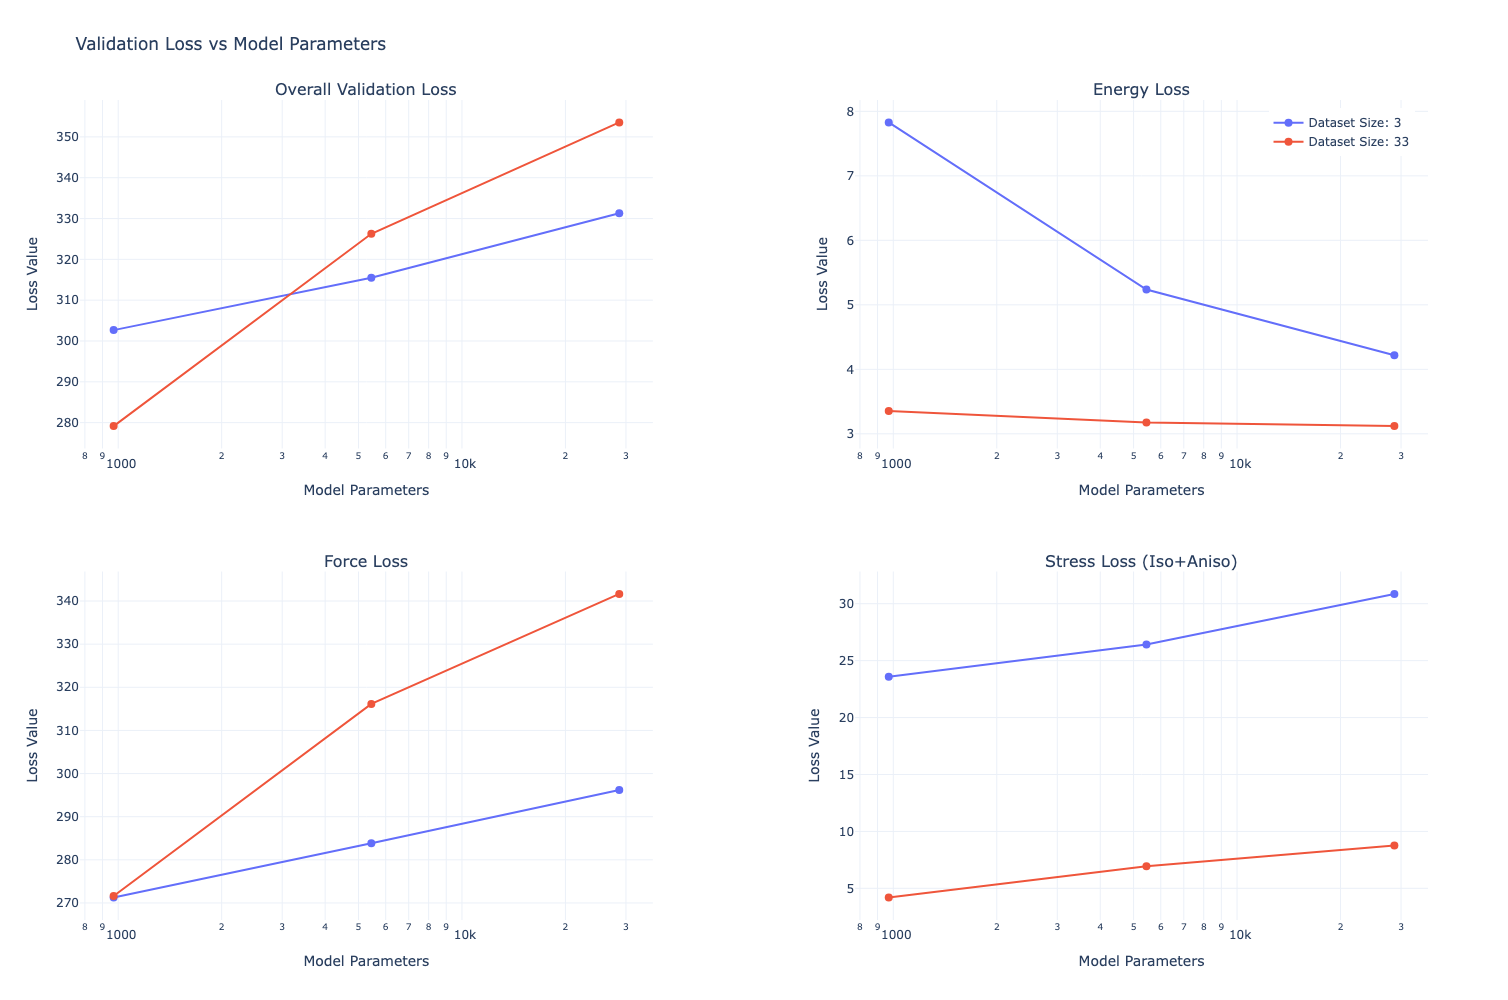

In [111]:
# Display plots directly when cell is run
if 'best_losses' in globals() and best_losses:
    print("Creating parameter vs loss plots...")
    fig = plot_params_vs_losses(best_losses)
    if fig:
        fig.show()
else:
    print("No data loaded. Please load data first.")